**5p - 3** Mediante el dataset **Financial PhraseBank** (para
las frases **100% agree** con el dataset de clase) construir un clasificador de sentimientos con las
siguientes técnicas. Comparar sobre test los resultados de vuestro modelo con algún modelo de
análisis de sentimiento ya implementado como nltk y etc:

Se evaluarán los resultados en función de la distancia al benchmark 0.98 acc(allagree), la 
complejidad de la solución (embeddings utilizados y entrenados, etc) y la
explicación del proceso.
- Redes recurrentes
- Redes convolucionales
- transformers

In [245]:
# Vamos a cargar los datos que vamos a utilizar en todos los ejercicios
import pandas as pd
dataset_df = pd.read_csv(
    'Sentences_AllAgree.csv',
    header=None,
    encoding="iso-8859-1")
dataset_df.columns = ['sentence', 'sentiment', 'sentence_clear', 'label']

In [246]:
dataset_df.value_counts('sentiment'),dataset_df.value_counts('label')

(sentiment
 neutral     1390
 positive     570
 negative     303
 dtype: int64,
 label
 1    1390
 2     570
 0     303
 dtype: int64)

Vamos a realizar las particiones que vamos a utilizar en los ejercicios, realizaremos la partición con sklearn

In [247]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

dataset_df = shuffle(dataset_df,random_state=42).reset_index(drop=True) # random_state=42 para replicabilidad
dataset_df.head()

,sentence,sentiment,sentence_clear,label
0,- The Group -Â¦ s sales during the period were...,neutral,group sale period eur 316 million eur 366 mi...,1
1,Finnish investment company Neomarkka is the ma...,neutral,finnish investment company neomarkka main owne...,1
2,The company slipped to an operating loss of EU...,negative,company slip operate loss eur 26 million profi...,0
3,According to Atria 's President and CEO Matti ...,positive,accord atrium president ceo matti tikkakoski ...,2
4,"In 2009 , Fiskars ' cash flow from operating a...",positive,2009 fiskars cash flow operate activity amou...,2


In [248]:
# Vamos a dividir el dataset en train y test
x_train, x_test, y_train, y_test = train_test_split(
    dataset_df['sentence'].tolist(),
    dataset_df['label'].tolist(),
    test_size=0.3, 
    random_state=42)# ponemos random_state para que sea reproducible

Vamos a hacer una representación para saber la longitud máxima de las frases

<AxesSubplot:>

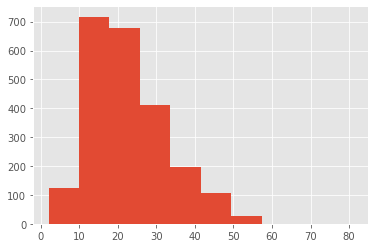

In [249]:
dataset_df['sentence'].apply(lambda x: len(x.split(" "))).hist()

Longitud máxima 60, esto lo tendremos que tener en cuenta a la hora de poner el padding

In [250]:
maxlen = 60

### Redes recurrentes

Vamos a usar un preprocesado de hugginface que se puede ver [aquí](https://huggingface.co/docs/transformers/preprocessing)

- Es uno de los que se utilizan para bert

In [251]:
from transformers import AutoTokenizer
import tensorflow as tf
import numpy as np

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

Vamos a utilizar el tokenizador de BERT, ya que este nos incluye directamente los tokens de \<start\> \<end\> y \<padding\>, nos convierte los resultados en tensores de tensorflow, añade el padding, se puede elegir la longitud máxima.

**No** Vamos a utilizar el embedding de BERT ya que queremos entrenar el nuestro propio, para el caso del transformer no será así.

In [252]:
# Vamos a tokenizar el texto con el tokenizer de BERT y a convertirlo en un tensor de longitud fija 60
encoded_input_train  = tokenizer(x_train, padding=True, truncation=True, max_length=60, return_tensors="tf")
x_train = encoded_input_train['input_ids']

encoded_input_test  = tokenizer(x_test, padding=True, truncation=True, max_length=60, return_tensors="tf")
x_test = encoded_input_test['input_ids']


In [253]:
n_features = [i.tolist() for i in x_train.numpy()]
# unpacking list
n_features = [item for sublist in n_features for item in sublist]
# counting number of unique elements
max_features = len(set(n_features))
print('El número de palabras únicas es :', max_features)

El número de palabras únicas es : 5389


Vamos a definir el modelo

In [254]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, Flatten

In [278]:
model_recurrente = Sequential()
# Max features es el número es palabras únicas que tenemos en el vocabulario
model_recurrente.add(Embedding(
            input_dim=max_features,
            output_dim=256,
            input_length=maxlen,
            trainable=True
        ))
model_recurrente.add(Dropout(0.5))
model_recurrente.add(Bidirectional(LSTM(25, return_sequences=True)))
model_recurrente.add(Dropout(0.5))
model_recurrente.add(Bidirectional(LSTM(25, return_sequences=True)))
model_recurrente.add(Dropout(0.5))
model_recurrente.add(Flatten())
model_recurrente.add(Dense(32, activation='relu'))
model_recurrente.add(Dense(16, activation='relu'))
model_recurrente.add(Dense(3, activation='softmax'))



In [279]:
model_recurrente.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_33 (Embedding)    (None, 60, 256)           1379584   
                                                                 
 dropout_79 (Dropout)        (None, 60, 256)           0         
                                                                 
 bidirectional_28 (Bidirecti  (None, 60, 50)           56400     
 onal)                                                           
                                                                 
 dropout_80 (Dropout)        (None, 60, 50)            0         
                                                                 
 bidirectional_29 (Bidirecti  (None, 60, 50)           15200     
 onal)                                                           
                                                                 
 dropout_81 (Dropout)        (None, 60, 50)          

Hemos probado distintos learning rates, con este conseguimos que aprenda a un ritmo suficiente, y que no sobre ajuste demasiado rápido

In [280]:
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
model_recurrente.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Vamos a definir los callbacks

In [281]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-8)

In [282]:
print('Train...')
batch_size=4
epochs=100
validation_split=0.2

history = model_recurrente.fit(x_train, np.array(y_train),
          batch_size=batch_size,
          epochs=epochs,
          validation_split=validation_split,
          verbose=1,
          callbacks=[early_stopping, reduce_lr])



Train...
Epoch 1/100
317/317 [==============================] - 22s 43ms/step - loss: 0.9962 - accuracy: 0.5683 - val_loss: 0.8910 - val_accuracy: 0.6183 - lr: 3.0000e-05
Epoch 2/100
317/317 [==============================] - 11s 34ms/step - loss: 0.8782 - accuracy: 0.6117 - val_loss: 0.8535 - val_accuracy: 0.6183 - lr: 3.0000e-05
Epoch 3/100
317/317 [==============================] - 11s 33ms/step - loss: 0.8239 - accuracy: 0.6243 - val_loss: 0.7856 - val_accuracy: 0.6782 - lr: 3.0000e-05
Epoch 4/100
317/317 [==============================] - 10s 33ms/step - loss: 0.7169 - accuracy: 0.6772 - val_loss: 0.7129 - val_accuracy: 0.7098 - lr: 3.0000e-05
Epoch 5/100
317/317 [==============================] - 11s 34ms/step - loss: 0.6216 - accuracy: 0.7301 - val_loss: 0.6710 - val_accuracy: 0.7192 - lr: 3.0000e-05
Epoch 6/100
317/317 [==============================] - 11s 33ms/step - loss: 0.5684 - accuracy: 0.7553 - val_loss: 0.6462 - val_accuracy: 0.7319 - lr: 3.0000e-05
Epoch 7/100
317/317

Text(0, 0.5, 'Accuracy')

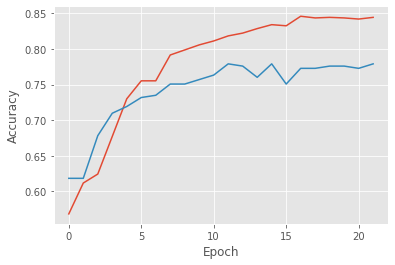

In [284]:
# Vamos a mostrar las métricas
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Text(0, 0.5, 'loss')

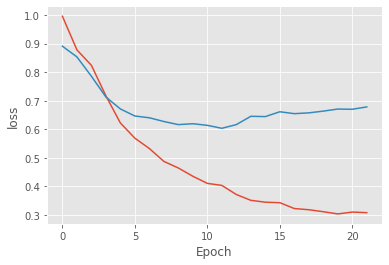

In [285]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')

In [286]:
model_recurrente.evaluate(x_test, np.array(y_test))

22/22 [==============================] - 1s 21ms/step - loss: 0.5504 - accuracy: 0.7850


[0.5504391193389893, 0.784977912902832]

He probado varias configuraciones, hay algunas con solo lstm no bidireccionales y con menos dropout que funcionaban mejor, pero este tipo de modelo es el único que no se sobreajustaba a las 4 épocas. Se podría reducir más el overfitting pero considero que este es un resultado suficientemente bueno para el tipo de estructura 

- El porcentaje del predictor por defecto sería 61,4%, con este modelo se consigue un ~78,5%
- Al final de este ejercicio se realizará una comparación de todos los modelos

In [287]:
model_recurrente.save('model_recurrente.h5')

### Redes convolucionales

En este caso tambien vamos a utilizar el tokenizar de BERT, pero **no** vamos a usar su embbeding. Vamos a utilizar los mismos datos que hemos preparado en el ejercicio anterior.

In [ ]:
x_train.shape

TensorShape([1584, 60])

En este caso vamos a definir el modelo de manera funcional, para poder usar convoluciones de distintas longitudes

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Convolution1D, MaxPooling1D, Input, concatenate, GlobalMaxPooling1D, GlobalAveragePooling1D

In [270]:
# Modelo convolucional funcional
model_input = tf.keras.Input(shape=(60,), dtype='int32')
# Usamos el mismo tipo embedding que en el modelo recurrente
embbeding_model = Embedding(
            input_dim=max_features,
            output_dim=256,
            input_length=maxlen,
            trainable=True
        )
x = embbeding_model(model_input)
x = Dropout(0.5)(x)

# Creamos 6 capas convolucionales con diferentes tamaños de ventana 
conv_7 = Convolution1D(128, 7, activation='relu')(x)
conv_6 = Convolution1D(128, 6, activation='relu')(x)
conv_5 = Convolution1D(128, 5, activation='relu')(x)
conv_4 = Convolution1D(128, 4, activation='relu')(x)
conv_3 = Convolution1D(128, 3, activation='relu')(x)
conv_2 = Convolution1D(128, 2, activation='relu')(x)

# Max pooling de cada capa convolucional, para quedarnos con el patrón más relevante
maxpool_7 = MaxPooling1D(3)(conv_7)
maxpool_6 = MaxPooling1D(3)(conv_6)
maxpool_5 = MaxPooling1D(3)(conv_5)
maxpool_4 = MaxPooling1D(3)(conv_4)
maxpool_3 = MaxPooling1D(3)(conv_3)
maxpool_2 = MaxPooling1D(3)(conv_2)

# Concatenamos las capas convolucionales y le realizamos un global max pooling
# para quedarnos con el patrón más relevante
# hemos probado con global average pooling y no ha mejorado el modelo (aumentaba el overfitting)
z = concatenate([
    GlobalMaxPooling1D()(maxpool_7),
    GlobalMaxPooling1D()(maxpool_6),
    GlobalMaxPooling1D()(maxpool_5),
    GlobalMaxPooling1D()(maxpool_4),
    GlobalMaxPooling1D()(maxpool_3), 
    GlobalMaxPooling1D()(maxpool_2)])
z = Dropout(0.5)(z)

# Añadimos una capa densa con 32 neuronas y una capa densa con 16 neuronas
# y una capa de salida con 3 neuronas (una por cada clase)

z = Dense(32, activation='relu')(z)
z = Dense(16, activation='relu')(z)
model_output = Dense(3, activation='softmax')(z)

model_convolutional = Model(model_input, model_output)

In [271]:
model_convolutional.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 60)]         0           []                               
                                                                                                  
 embedding_32 (Embedding)       (None, 60, 256)      1379584     ['input_14[0][0]']               
                                                                                                  
 dropout_77 (Dropout)           (None, 60, 256)      0           ['embedding_32[0][0]']           
                                                                                                  
 conv1d_48 (Conv1D)             (None, 54, 128)      229504      ['dropout_77[0][0]']             
                                                                                           

In [272]:
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)
model_convolutional.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Vamos a definir los callbacks

In [273]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-8)

Entrenamos el modelo

In [274]:
print('Train...')
batch_size=4
epochs=100
validation_split=0.2

history = model_convolutional.fit(x_train, np.array(y_train),
          batch_size=batch_size,
          epochs=epochs,
          validation_split=validation_split,
          verbose=1,
          callbacks=[early_stopping, reduce_lr])



Train...
Epoch 1/100
317/317 [==============================] - 10s 23ms/step - loss: 0.8558 - accuracy: 0.6448 - val_loss: 0.7870 - val_accuracy: 0.6877 - lr: 3.0000e-04
Epoch 2/100
317/317 [==============================] - 6s 19ms/step - loss: 0.6379 - accuracy: 0.7388 - val_loss: 0.6292 - val_accuracy: 0.7445 - lr: 3.0000e-04
Epoch 3/100
317/317 [==============================] - 6s 19ms/step - loss: 0.4972 - accuracy: 0.7908 - val_loss: 0.5509 - val_accuracy: 0.7792 - lr: 3.0000e-04
Epoch 4/100
317/317 [==============================] - 6s 19ms/step - loss: 0.3941 - accuracy: 0.8224 - val_loss: 0.4858 - val_accuracy: 0.8265 - lr: 3.0000e-04
Epoch 5/100
317/317 [==============================] - 6s 19ms/step - loss: 0.2872 - accuracy: 0.8753 - val_loss: 0.4459 - val_accuracy: 0.8580 - lr: 3.0000e-04
Epoch 6/100
317/317 [==============================] - 6s 19ms/step - loss: 0.2024 - accuracy: 0.9171 - val_loss: 0.4217 - val_accuracy: 0.8707 - lr: 3.0000e-04
Epoch 7/100
317/317 [===

Text(0, 0.5, 'Accuracy')

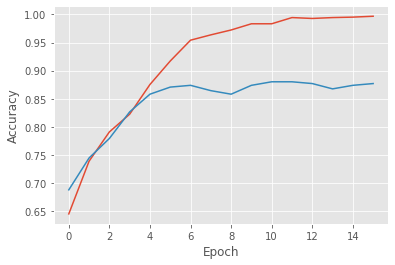

In [275]:
# Vamos a mostrar las métricas
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Text(0, 0.5, 'loss')

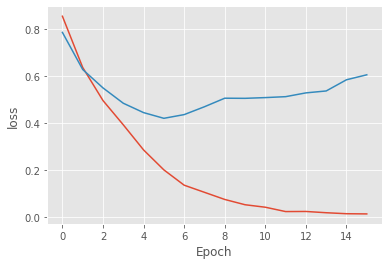

In [276]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')

In [277]:
model_convolutional.evaluate(x_test, np.array(y_test))

22/22 [==============================] - 1s 15ms/step - loss: 0.3909 - accuracy: 0.8557


[0.39094775915145874, 0.8556700944900513]

He probado varias configuraciones, si añado dropout en las últimas capas densas la red no es capaz de aprender. Se podría añadir distintos tipos de regularización como l1 y l2 en el problema, pero al probarlas no he obtenido mejores resultados, y serían demasiados hyperparámetros para hacer finetunning de los mismos. Se podría reducir más el overfitting pero considero que este es un resultado suficiente.

- El porcentaje del predictor por defecto sería 61,4%, con este modelo se consigue un ~85,6%
- Al final de este ejercicio se realizará una comparación de todos los modelos

In [268]:
model_convolutional.save('model_convolutional.h5')

### Transformer